In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp
import numpy as np
from typing import List
import time

# Âü∫Êú¨„Éë„É©„É°„Éº„Çø
PERIOD = 7.2  # mm (1030nm‰ΩçÁõ∏Êï¥ÂêàÊ≥¢Èï∑)
TOTAL_DOMAINS = 600
DEVICE_LENGTH = PERIOD * TOTAL_DOMAINS / 2  # Â§ß‰Ωì10mm
KAPPA = 1.031E-05
WAVELENGTH_RANGE = jnp.linspace(1.02, 1.04, 500).tolist()  # 1030nmÂë®Ëæ∫„ÅÆÂ∫ÉÂ∏ØÂüü
TEMP = 20.0

# Â∏ØÂüüÂπÖË®àÁÆó„ÅÆÂü∫Ê∫ñË®≠ÂÆö
BANDWIDTH_THRESHOLD = 0.99  # 95%Âü∫Ê∫ñ

# Ë™øÊï¥Â±§ÂπÖ„ÅÆÁØÑÂõ≤ (Âë®Êúü„Éô„Éº„Çπ)
ADJUST_WIDTH_MIN = PERIOD * 0.4   # Âë®Êúü„ÅÆ0.4ÂÄç
ADJUST_WIDTH_MAX = PERIOD * 1.6   # Âë®Êúü„ÅÆ1.6ÂÄç
NUM_WIDTH_STEPS = 1000

# Ë™øÊï¥Â±§‰ΩçÁΩÆ„ÅÆÁØÑÂõ≤ (1„Åã„Çâ599„ÄÅÊúÄÂàù„Å®ÊúÄÂæå„ÅØÈô§Â§ñ)
ADJUST_POSITION_START = 1
ADJUST_POSITION_END = TOTAL_DOMAINS - 1

print(f"Âü∫Êú¨Âë®Êúü: {PERIOD:.1f} mm")
print(f"Á∑è„Éâ„É°„Ç§„É≥Êï∞: {TOTAL_DOMAINS}")
print(f"„Éá„Éê„Ç§„ÇπÈï∑: {DEVICE_LENGTH:.1f} mm")
print(
    f"Ë®àÁÆóÊ≥¢Èï∑ÁØÑÂõ≤: {min(WAVELENGTH_RANGE):.3f} - {max(WAVELENGTH_RANGE):.3f} Œºm (1030nmÂë®Ëæ∫)")
print(f"Â∏ØÂüüÂπÖÂü∫Ê∫ñ: {BANDWIDTH_THRESHOLD*100:.0f}%")
print(f"Ë™øÊï¥Â±§ÂπÖÁØÑÂõ≤: {ADJUST_WIDTH_MIN:.2f} - {ADJUST_WIDTH_MAX:.2f} mm (Âë®Êúü„ÅÆ{ADJUST_WIDTH_MIN/PERIOD:.1f}ÂÄçÔΩû{ADJUST_WIDTH_MAX/PERIOD:.1f}ÂÄç)")
print(f"Ë™øÊï¥Â±§‰ΩçÁΩÆÁØÑÂõ≤: {ADJUST_POSITION_START} - {ADJUST_POSITION_END}")
print(
    f"Á∑èÊé¢Á¥¢„Éë„Çø„Éº„É≥Êï∞: {NUM_WIDTH_STEPS * (ADJUST_POSITION_END - ADJUST_POSITION_START):.0f}")
print(
    f"\\nË´ñÊñá„ÅÆÊúÄÈÅ©ÂÄ§: Âë®Êúü„Å®Âêå„ÅòÂπÖ = {PERIOD:.1f} mm, ‰ΩçÁΩÆ = 0.165L = {0.165*TOTAL_DOMAINS:.0f}Áï™ÁõÆ„ÅÆ„Éâ„É°„Ç§„É≥")

Âü∫Êú¨Âë®Êúü: 7.2 mm
Á∑è„Éâ„É°„Ç§„É≥Êï∞: 600
„Éá„Éê„Ç§„ÇπÈï∑: 2160.0 mm
Ë®àÁÆóÊ≥¢Èï∑ÁØÑÂõ≤: 1.020 - 1.040 Œºm (1030nmÂë®Ëæ∫)
Â∏ØÂüüÂπÖÂü∫Ê∫ñ: 99%
Ë™øÊï¥Â±§ÂπÖÁØÑÂõ≤: 2.88 - 11.52 mm (Âë®Êúü„ÅÆ0.4ÂÄçÔΩû1.6ÂÄç)
Ë™øÊï¥Â±§‰ΩçÁΩÆÁØÑÂõ≤: 1 - 599
Á∑èÊé¢Á¥¢„Éë„Çø„Éº„É≥Êï∞: 598000
\nË´ñÊñá„ÅÆÊúÄÈÅ©ÂÄ§: Âë®Êúü„Å®Âêå„ÅòÂπÖ = 7.2 mm, ‰ΩçÁΩÆ = 0.165L = 99Áï™ÁõÆ„ÅÆ„Éâ„É°„Ç§„É≥


In [2]:
def create_two_segment_pros_all() -> shg.DomainTensor:
    """
    2„Çª„Ç∞„É°„É≥„ÉàPROSÊßãÈÄ†„ÅÆÂÖ®„Éë„Çø„Éº„É≥„Çí‰∏ÄÂ∫¶„Å´ÁîüÊàê

    Returns:
        DomainTensor (shape: total_patterns, TOTAL_DOMAINS, 2)
    """
    # Ë™øÊï¥Â±§ÂπÖ„Å®‰ΩçÁΩÆ„ÅÆÈÖçÂàó„Çí‰ΩúÊàê
    adjust_widths = jnp.linspace(
        ADJUST_WIDTH_MIN, ADJUST_WIDTH_MAX, NUM_WIDTH_STEPS)
    adjust_positions = jnp.arange(ADJUST_POSITION_START, ADJUST_POSITION_END)

    # „É°„ÉÉ„Ç∑„É•„Ç∞„É™„ÉÉ„Éâ„ÅßÂÖ®ÁµÑ„ÅøÂêà„Çè„Åõ„Çí‰ΩúÊàê
    width_grid, pos_grid = jnp.meshgrid(
        adjust_widths, adjust_positions, indexing='ij')
    width_flat = width_grid.flatten()  # (total_patterns,)
    pos_flat = pos_grid.flatten()      # (total_patterns,)

    total_patterns = len(width_flat)

    # Âü∫Êú¨ÂπÖ„ÅÆÈÖçÂàó„Çí‰ΩúÊàê (total_patterns, TOTAL_DOMAINS)
    base_widths = jnp.full((total_patterns, TOTAL_DOMAINS), PERIOD / 2)

    # Ë™øÊï¥Â±§‰ΩçÁΩÆ„ÅÆ„Éû„Çπ„ÇØ„Çí‰ΩúÊàê
    domain_indices = jnp.arange(TOTAL_DOMAINS)  # (TOTAL_DOMAINS,)
    # (total_patterns, TOTAL_DOMAINS)
    pos_mask = domain_indices[None, :] == pos_flat[:, None]

    # Ë™øÊï¥Â±§„ÅÆÂπÖ„ÇíÈÅ©Áî®
    widths = jnp.where(pos_mask, width_flat[:, None], base_widths)

    # „Ç´„ÉÉ„ÉëÂÄ§„ÇíË®≠ÂÆöÔºàÂÅ∂Êï∞„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: +, Â•áÊï∞„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: -Ôºâ
    kappa_pattern = jnp.where(domain_indices % 2 == 0, KAPPA, -KAPPA)
    kappas = jnp.broadcast_to(kappa_pattern, (total_patterns, TOTAL_DOMAINS))

    # „ÉÜ„É≥„ÇΩ„É´„Çí‰ΩúÊàê
    tensor = jnp.stack([widths, kappas], axis=-1)
    return tensor


print("ÂÆåÂÖ®‰∏¶ÂàóÂåñ„Åï„Çå„Åü2„Çª„Ç∞„É°„É≥„ÉàPROSÊßãÈÄ†ÁîüÊàêÈñ¢Êï∞„ÇíÂÆöÁæ©„Åó„Åæ„Åó„Åü")

ÂÆåÂÖ®‰∏¶ÂàóÂåñ„Åï„Çå„Åü2„Çª„Ç∞„É°„É≥„ÉàPROSÊßãÈÄ†ÁîüÊàêÈñ¢Êï∞„ÇíÂÆöÁæ©„Åó„Åæ„Åó„Åü


In [3]:
# ÂÖ®„Éë„Çø„Éº„É≥„Çí‰∏ÄÂ∫¶„Å´ÁîüÊàê
print("ÂÖ®„Éë„Çø„Éº„É≥„ÅÆPROSÊßãÈÄ†„ÇíÁîüÊàê‰∏≠...")
start_time = time.time()

pros_tensor = create_two_segment_pros_all()

generation_time = time.time() - start_time
print(f"ÊßãÈÄ†ÁîüÊàêÂÆå‰∫Ü: {generation_time:.2f}Áßí")
print(f"ÁîüÊàê„Åï„Çå„Åü„ÉÜ„É≥„ÇΩ„É´ÂΩ¢Áä∂: {pros_tensor.shape}")
print(f"„É°„É¢„É™‰ΩøÁî®Èáè: {pros_tensor.nbytes / 1e9:.2f} GB")

# Ë™øÊï¥Â±§ÂπÖ„Å®‰ΩçÁΩÆ„ÅÆÈÖçÂàóÔºàÂæå„ÅßÁµêÊûúÂàÜÊûê„Å´‰ΩøÁî®Ôºâ
adjust_widths = jnp.linspace(
    ADJUST_WIDTH_MIN, ADJUST_WIDTH_MAX, NUM_WIDTH_STEPS)
adjust_positions = jnp.arange(ADJUST_POSITION_START, ADJUST_POSITION_END)
total_patterns = len(adjust_widths) * len(adjust_positions)

print(f"Ë™øÊï¥Â±§ÂπÖ„Éë„Çø„Éº„É≥Êï∞: {len(adjust_widths)}")
print(f"Ë™øÊï¥Â±§‰ΩçÁΩÆ„Éë„Çø„Éº„É≥Êï∞: {len(adjust_positions)}")
print(f"Á∑è„Éë„Çø„Éº„É≥Êï∞: {total_patterns}")

ÂÖ®„Éë„Çø„Éº„É≥„ÅÆPROSÊßãÈÄ†„ÇíÁîüÊàê‰∏≠...
ÊßãÈÄ†ÁîüÊàêÂÆå‰∫Ü: 0.75Áßí
ÁîüÊàê„Åï„Çå„Åü„ÉÜ„É≥„ÇΩ„É´ÂΩ¢Áä∂: (598000, 600, 2)
„É°„É¢„É™‰ΩøÁî®Èáè: 2.87 GB
Ë™øÊï¥Â±§ÂπÖ„Éë„Çø„Éº„É≥Êï∞: 1000
Ë™øÊï¥Â±§‰ΩçÁΩÆ„Éë„Çø„Éº„É≥Êï∞: 598
Á∑è„Éë„Çø„Éº„É≥Êï∞: 598000


In [4]:
def calculate_bandwidth(efficiency_spectrum: jnp.ndarray, threshold: float = 0.5) -> float:
    """
    ÂäπÁéá„Çπ„Éö„ÇØ„Éà„É©„É†„Åã„ÇâÂ∏ØÂüüÂπÖ„ÇíË®àÁÆó

    Args:
        efficiency_spectrum: ÂäπÁéá„Çπ„Éö„ÇØ„Éà„É©„É†ÈÖçÂàó
        threshold: Â∏ØÂüüÂπÖË®àÁÆó„ÅÆÈñæÂÄ§ÔºàÊúÄÂ§ßÂÄ§„Å´ÂØæ„Åô„ÇãÊØîÁéáÔºâ

    Returns:
        Â∏ØÂüüÂπÖ (Œºm)
    """
    max_eff = jnp.max(efficiency_spectrum)
    above_threshold = efficiency_spectrum >= max_eff * threshold

    if jnp.sum(above_threshold) == 0:
        return 0.0

    # ÈñæÂÄ§„ÇíË∂Ö„Åà„ÇãÊ≥¢Èï∑ÁØÑÂõ≤„ÇíË®àÁÆó
    wavelength_array = jnp.array(WAVELENGTH_RANGE)
    valid_wavelengths = wavelength_array[above_threshold]

    return jnp.max(valid_wavelengths) - jnp.min(valid_wavelengths)


print("Â∏ØÂüüÂπÖË®àÁÆóÈñ¢Êï∞„ÇíÂÆöÁæ©„Åó„Åæ„Åó„Åü")

Â∏ØÂüüÂπÖË®àÁÆóÈñ¢Êï∞„ÇíÂÆöÁæ©„Åó„Åæ„Åó„Åü


In [5]:
# ÂÖ®„Éë„Çø„Éº„É≥„ÅÆSHGËß£Êûê„Çí‰∏ÄÂ∫¶„Å´ÂÆüË°å
print("ÂÖ®„Éë„Çø„Éº„É≥„ÅÆSHGËß£Êûê„ÇíÈñãÂßã...")
start_time = time.time()

# SHGËß£Êûê
shg_params = shg.Params(
    grating_dim=pros_tensor,
    T_dim=[TEMP],
    wavelength_dim=WAVELENGTH_RANGE,
    fund_power_dim=1,
    sh_power_dim=0
)

eff_tensor = shg.analyze(shg_params, mgoslt.use_material, shg.solve_ncme_npda)
power = jnp.abs(eff_tensor[:, 0, :, 0, 0])**2

analysis_time = time.time() - start_time
print(f"SHGËß£ÊûêÂÆå‰∫Ü: {analysis_time:.2f}Áßí")
print(f"ÂäπÁéá„ÉÜ„É≥„ÇΩ„É´ÂΩ¢Áä∂: {power.shape}")

# ÂêÑ„Éë„Çø„Éº„É≥„ÅÆÊúÄÂ§ßÂäπÁéá
max_efficiencies = jnp.max(power, axis=1)

# ‰øÆÊ≠£„Åï„Çå„ÅüË©ï‰æ°Èñ¢Êï∞ÔºàÊ≠£Ë¶èÂåñÂü∫Ê∫ñ„Çí‰øùÂ≠òÔºâ


def calculate_vectorized_metrics_fixed(power_matrix: jnp.ndarray, threshold: float = BANDWIDTH_THRESHOLD,
                                       global_max_eff: float = None, global_max_bw: float = None) -> tuple:
    """
    ‰øÆÊ≠£Áâà: Ê≠£Ë¶èÂåñÂü∫Ê∫ñ„ÇíÂ§ñÈÉ®„Åã„ÇâÊåáÂÆöÂèØËÉΩ
    """
    # ÂêÑ„Éë„Çø„Éº„É≥„ÅÆÊúÄÂ§ßÂÄ§
    max_effs = jnp.max(power_matrix, axis=1, keepdims=True)  # (N, 1)

    # ÈñæÂÄ§„ÇíË∂Ö„Åà„ÇãÊ≥¢Èï∑„ÅÆ„Éû„Çπ„ÇØ
    above_threshold = power_matrix >= max_effs * threshold  # (N, W)

    # 1. ÂÆüÂäπÂ∏ØÂüüÂπÖÔºàÈñæÂÄ§„ÇíË∂Ö„Åà„ÇãÁÇπ„ÅÆÂØÜÂ∫¶„ÇíËÄÉÊÖÆÔºâ
    wavelength_step = (max(WAVELENGTH_RANGE) -
                       min(WAVELENGTH_RANGE)) / len(WAVELENGTH_RANGE)
    effective_bandwidth = jnp.sum(above_threshold, axis=1) * wavelength_step

    # 2. Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢Ôºà„Éô„ÇØ„Éà„É´ÂåñÁâàÔºâ
    has_valid_points = jnp.sum(above_threshold, axis=1) > 0  # (N,)
    valid_power_sum = jnp.sum(
        jnp.where(above_threshold, power_matrix, 0.0), axis=1)
    valid_power_mean = jnp.where(has_valid_points,
                                 valid_power_sum /
                                 jnp.sum(above_threshold, axis=1),
                                 0.0)

    # ÂàÜÊï£Ë®àÁÆó
    squared_diff = jnp.where(above_threshold,
                             (power_matrix - valid_power_mean[:, None])**2,
                             0.0)
    valid_power_var = jnp.where(has_valid_points,
                                jnp.sum(squared_diff, axis=1) /
                                jnp.sum(above_threshold, axis=1),
                                jnp.inf)

    # Ê≠£Ë¶èÂåñÂàÜÊï£„ÅÆÈÄÜÊï∞ÔºàÂπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢Ôºâ
    normalized_std = jnp.sqrt(valid_power_var) / (valid_power_mean + 1e-10)
    flatness_score = jnp.where(
        has_valid_points, 1.0 / (1.0 + normalized_std), 0.0)

    # 3. Ë§áÂêà„Çπ„Ç≥„Ç¢Ôºà‰øÆÊ≠£ÁâàÔºö„Ç∞„É≠„Éº„Éê„É´Âü∫Ê∫ñ„ÅßÊ≠£Ë¶èÂåñÔºâ
    if global_max_eff is None:
        global_max_eff = jnp.max(max_effs)
    if global_max_bw is None:
        global_max_bw = jnp.max(effective_bandwidth)

    # „Ç∞„É≠„Éº„Éê„É´Âü∫Ê∫ñ„ÅßÊ≠£Ë¶èÂåñ
    norm_eff_bw = effective_bandwidth / (global_max_bw + 1e-10)
    norm_flatness = flatness_score  # Âπ≥Âù¶ÊÄß„ÅØ0-1„ÅÆÁØÑÂõ≤„Å™„ÅÆ„ÅßÊ≠£Ë¶èÂåñ‰∏çË¶Å
    norm_efficiency = max_effs.squeeze() / global_max_eff

    # Èáç„Åø‰ªò„ÅçË§áÂêà„Çπ„Ç≥„Ç¢
    composite_score = (norm_eff_bw**0.4) * \
        (norm_flatness**0.3) * (norm_efficiency**0.3)

    return effective_bandwidth, flatness_score, composite_score


# „Åæ„ÅöÂÖ®„Éê„ÉÉ„ÉÅ„ÅßË®àÁÆó„Åó„Å¶Ê≠£Ë¶èÂåñÂü∫Ê∫ñ„ÇíÂèñÂæó
effective_bandwidths, flatness_scores, _ = calculate_vectorized_metrics_fixed(
    power, BANDWIDTH_THRESHOLD)
global_max_eff = jnp.max(max_efficiencies)
global_max_bw = jnp.max(effective_bandwidths)

print(f"Ê≠£Ë¶èÂåñÂü∫Ê∫ñ: ÊúÄÂ§ßÂäπÁéá={global_max_eff:.8f}, ÊúÄÂ§ßÂ∏ØÂüüÂπÖ={global_max_bw*1000:.1f}nm")

# Ê≠£Ë¶èÂåñÂü∫Ê∫ñ„ÇíÂõ∫ÂÆö„Åó„Å¶ÂÜçË®àÁÆó
_, _, composite_scores = calculate_vectorized_metrics_fixed(
    power, BANDWIDTH_THRESHOLD, global_max_eff, global_max_bw)

print(f"Ë®àÁÆóÂÆå‰∫Ü: ‰øÆÊ≠£ÁâàË©ï‰æ°ÊåáÊ®ô„ÇíÁÆóÂá∫")
print(f"- ÂÆüÂäπÂ∏ØÂüüÂπÖÊúÄÂ§ß: {global_max_bw*1000:.1f} nm")
print(f"- Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢ÊúÄÂ§ß: {jnp.max(flatness_scores):.3f}")
print(f"- Ë§áÂêà„Çπ„Ç≥„Ç¢ÊúÄÂ§ß: {jnp.max(composite_scores):.3f}")

# ÂÜçÂà©Áî®ÂèØËÉΩ„Å™Ë©ï‰æ°Èñ¢Êï∞„Å®„Åó„Å¶ÂÆöÁæ©


def calculate_single_metrics(power_spectrum: jnp.ndarray) -> tuple:
    """Âçò‰Ωì„Çπ„Éö„ÇØ„Éà„É©„É†Áî®„ÅÆË©ï‰æ°Èñ¢Êï∞Ôºà„Ç∞„É≠„Éº„Éê„É´Âü∫Ê∫ñ‰ΩøÁî®Ôºâ"""
    return calculate_vectorized_metrics_fixed(power_spectrum[None, :], BANDWIDTH_THRESHOLD, global_max_eff, global_max_bw)

ÂÖ®„Éë„Çø„Éº„É≥„ÅÆSHGËß£Êûê„ÇíÈñãÂßã...
SHGËß£ÊûêÂÆå‰∫Ü: 5.61Áßí
ÂäπÁéá„ÉÜ„É≥„ÇΩ„É´ÂΩ¢Áä∂: (598000, 500)
Ê≠£Ë¶èÂåñÂü∫Ê∫ñ: ÊúÄÂ§ßÂäπÁéá=0.00020100, ÊúÄÂ§ßÂ∏ØÂüüÂπÖ=0.8nm
Ë®àÁÆóÂÆå‰∫Ü: ‰øÆÊ≠£ÁâàË©ï‰æ°ÊåáÊ®ô„ÇíÁÆóÂá∫
- ÂÆüÂäπÂ∏ØÂüüÂπÖÊúÄÂ§ß: 0.8 nm
- Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢ÊúÄÂ§ß: 1.000
- Ë§áÂêà„Çπ„Ç≥„Ç¢ÊúÄÂ§ß: 0.784


In [6]:
# ÁµêÊûú„ÅÆÂàÜÊûêÔºàË§áÂêà„Çπ„Ç≥„Ç¢Âü∫Ê∫ñ„ÅßÊúÄÈÅ©ÂåñÔºâ
best_idx = jnp.argmax(composite_scores)  # Ë§áÂêà„Çπ„Ç≥„Ç¢„ÅßÈÅ∏Êäû
best_composite_score = composite_scores[best_idx]
best_effective_bandwidth = effective_bandwidths[best_idx]
best_flatness_score = flatness_scores[best_idx]
best_efficiency = max_efficiencies[best_idx]

# ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„ÇíÈÄÜÁÆó
width_idx = best_idx // len(adjust_positions)
pos_idx = best_idx % len(adjust_positions)
best_width = adjust_widths[width_idx]
best_position = adjust_positions[pos_idx]
best_spectrum = power[best_idx, :]

print("=== ÊúÄÈÅ©ÂåñÁµêÊûúÔºàË§áÂêà„Çπ„Ç≥„Ç¢Âü∫Ê∫ñÔºâ ===")
print(f"ÊúÄÈ´òË§áÂêà„Çπ„Ç≥„Ç¢: {best_composite_score:.6f}")
print(
    f"ÂÆüÂäπÂ∏ØÂüüÂπÖ: {best_effective_bandwidth:.6f} Œºm ({best_effective_bandwidth*1000:.1f} nm)")
print(f"Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢: {best_flatness_score:.6f}")
print(f"ÂäπÁéá: {best_efficiency:.8f}")
print(f"ÊúÄÈÅ©Ë™øÊï¥Â±§ÂπÖ: {best_width:.6f} mm ({best_width/PERIOD:.3f} √ó Âë®Êúü)")
print(
    f"ÊúÄÈÅ©Ë™øÊï¥Â±§‰ΩçÁΩÆ: {best_position} („Éâ„É°„Ç§„É≥„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ, {best_position/TOTAL_DOMAINS:.3f}L)")

# ‰ªñ„ÅÆÂü∫Ê∫ñ„Åß„ÅÆÊúÄÈÅ©Ëß£„ÇÇË°®Á§∫ÔºàÊØîËºÉÁî®Ôºâ
eff_bw_best_idx = jnp.argmax(effective_bandwidths)
efficiency_best_idx = jnp.argmax(max_efficiencies)
flatness_best_idx = jnp.argmax(flatness_scores)

print(f"\n=== ‰ªñ„ÅÆÂü∫Ê∫ñ„Åß„ÅÆÊúÄÈÅ©Ëß£ÔºàÊØîËºÉÁî®Ôºâ ===")
print(
    f"ÂÆüÂäπÂ∏ØÂüüÂπÖÊúÄÂ§ß: {effective_bandwidths[eff_bw_best_idx]*1000:.1f} nm (Ë§áÂêà„Çπ„Ç≥„Ç¢: {composite_scores[eff_bw_best_idx]:.6f})")
print(
    f"ÂäπÁéáÊúÄÂ§ß: {max_efficiencies[efficiency_best_idx]:.8f} (Ë§áÂêà„Çπ„Ç≥„Ç¢: {composite_scores[efficiency_best_idx]:.6f})")
print(
    f"Âπ≥Âù¶ÊÄßÊúÄÂ§ß: {flatness_scores[flatness_best_idx]:.6f} (Ë§áÂêà„Çπ„Ç≥„Ç¢: {composite_scores[flatness_best_idx]:.6f})")

# Áµ±Ë®àÊÉÖÂ†±
print(f"\n=== Áµ±Ë®àÊÉÖÂ†± ===")
print(f"ÂÆüÂäπÂ∏ØÂüüÂπÖ„ÅÆÂπ≥Âùá: {jnp.mean(effective_bandwidths)*1000:.1f} nm")
print(f"ÂÆüÂäπÂ∏ØÂüüÂπÖ„ÅÆÊúÄÂ§ßÂÄ§: {jnp.max(effective_bandwidths)*1000:.1f} nm")
print(f"Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢„ÅÆÂπ≥Âùá: {jnp.mean(flatness_scores):.6f}")
print(f"Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢„ÅÆÊúÄÂ§ßÂÄ§: {jnp.max(flatness_scores):.6f}")
print(f"Ë§áÂêà„Çπ„Ç≥„Ç¢„ÅÆÂπ≥Âùá: {jnp.mean(composite_scores):.6f}")
print(f"Ë§áÂêà„Çπ„Ç≥„Ç¢„ÅÆÊúÄÂ§ßÂÄ§: {jnp.max(composite_scores):.6f}")

# Ë´ñÊñáÊù°‰ª∂„Å®„ÅÆÊØîËºÉ
paper_optimal_position = int(0.165 * TOTAL_DOMAINS)
width_ratios = jnp.linspace(ADJUST_WIDTH_MIN/PERIOD,
                            ADJUST_WIDTH_MAX/PERIOD, NUM_WIDTH_STEPS)
closest_width_idx = jnp.argmin(jnp.abs(width_ratios - 1.0))
paper_width = adjust_widths[closest_width_idx]

print(f"\n=== Ë´ñÊñáÊù°‰ª∂„Å®„ÅÆÊØîËºÉ ===")
print(f"Ë´ñÊñáÊúÄÈÅ©Êù°‰ª∂: ÂπÖ={PERIOD:.1f}mm (Âë®Êúü√ó1.0), ‰ΩçÁΩÆ={paper_optimal_position} ({paper_optimal_position/TOTAL_DOMAINS:.3f}L)")
print(f"Êé¢Á¥¢ÊúÄÈÅ©Êù°‰ª∂: ÂπÖ={best_width:.1f}mm (Âë®Êúü√ó{best_width/PERIOD:.3f}), ‰ΩçÁΩÆ={best_position} ({best_position/TOTAL_DOMAINS:.3f}L)")

if abs(best_width - PERIOD) < 0.5 and abs(best_position - paper_optimal_position) < 10:
    print("‚úÖ Êé¢Á¥¢ÁµêÊûú„ÅØË´ñÊñáÊù°‰ª∂„Å´Ëøë„ÅÑÔºÅ")
else:
    print("‚ùå Êé¢Á¥¢ÁµêÊûú„ÅØË´ñÊñáÊù°‰ª∂„Å®Áï∞„Å™„Çã")

=== ÊúÄÈÅ©ÂåñÁµêÊûúÔºàË§áÂêà„Çπ„Ç≥„Ç¢Âü∫Ê∫ñÔºâ ===
ÊúÄÈ´òË§áÂêà„Çπ„Ç≥„Ç¢: 0.783953
ÂÆüÂäπÂ∏ØÂüüÂπÖ: 0.000760 Œºm (0.8 nm)
Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢: 0.997206
ÂäπÁéá: 0.00008954
ÊúÄÈÅ©Ë™øÊï¥Â±§ÂπÖ: 7.204325 mm (1.001 √ó Âë®Êúü)
ÊúÄÈÅ©Ë™øÊï¥Â±§‰ΩçÁΩÆ: 499 („Éâ„É°„Ç§„É≥„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ, 0.832L)

=== ‰ªñ„ÅÆÂü∫Ê∫ñ„Åß„ÅÆÊúÄÈÅ©Ëß£ÔºàÊØîËºÉÁî®Ôºâ ===
ÂÆüÂäπÂ∏ØÂüüÂπÖÊúÄÂ§ß: 0.8 nm (Ë§áÂêà„Çπ„Ç≥„Ç¢: 0.783953)
ÂäπÁéáÊúÄÂ§ß: 0.00020100 (Ë§áÂêà„Çπ„Ç≥„Ç¢: 0.477627)
Âπ≥Âù¶ÊÄßÊúÄÂ§ß: 1.000000 (Ë§áÂêà„Çπ„Ç≥„Ç¢: 0.347085)

=== Áµ±Ë®àÊÉÖÂ†± ===
ÂÆüÂäπÂ∏ØÂüüÂπÖ„ÅÆÂπ≥Âùá: 0.1 nm
ÂÆüÂäπÂ∏ØÂüüÂπÖ„ÅÆÊúÄÂ§ßÂÄ§: 0.8 nm
Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢„ÅÆÂπ≥Âùá: 0.997120
Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢„ÅÆÊúÄÂ§ßÂÄ§: 1.000000
Ë§áÂêà„Çπ„Ç≥„Ç¢„ÅÆÂπ≥Âùá: 0.464400
Ë§áÂêà„Çπ„Ç≥„Ç¢„ÅÆÊúÄÂ§ßÂÄ§: 0.783953

=== Ë´ñÊñáÊù°‰ª∂„Å®„ÅÆÊØîËºÉ ===
Ë´ñÊñáÊúÄÈÅ©Êù°‰ª∂: ÂπÖ=7.2mm (Âë®Êúü√ó1.0), ‰ΩçÁΩÆ=99 (0.165L)
Êé¢Á¥¢ÊúÄÈÅ©Êù°‰ª∂: ÂπÖ=7.2mm (Âë®Êúü√ó1.001), ‰ΩçÁΩÆ=499 (0.832L)
‚ùå Êé¢Á¥¢ÁµêÊûú„ÅØË´ñÊñáÊù°‰ª∂„Å®Áï∞„Å™„Çã


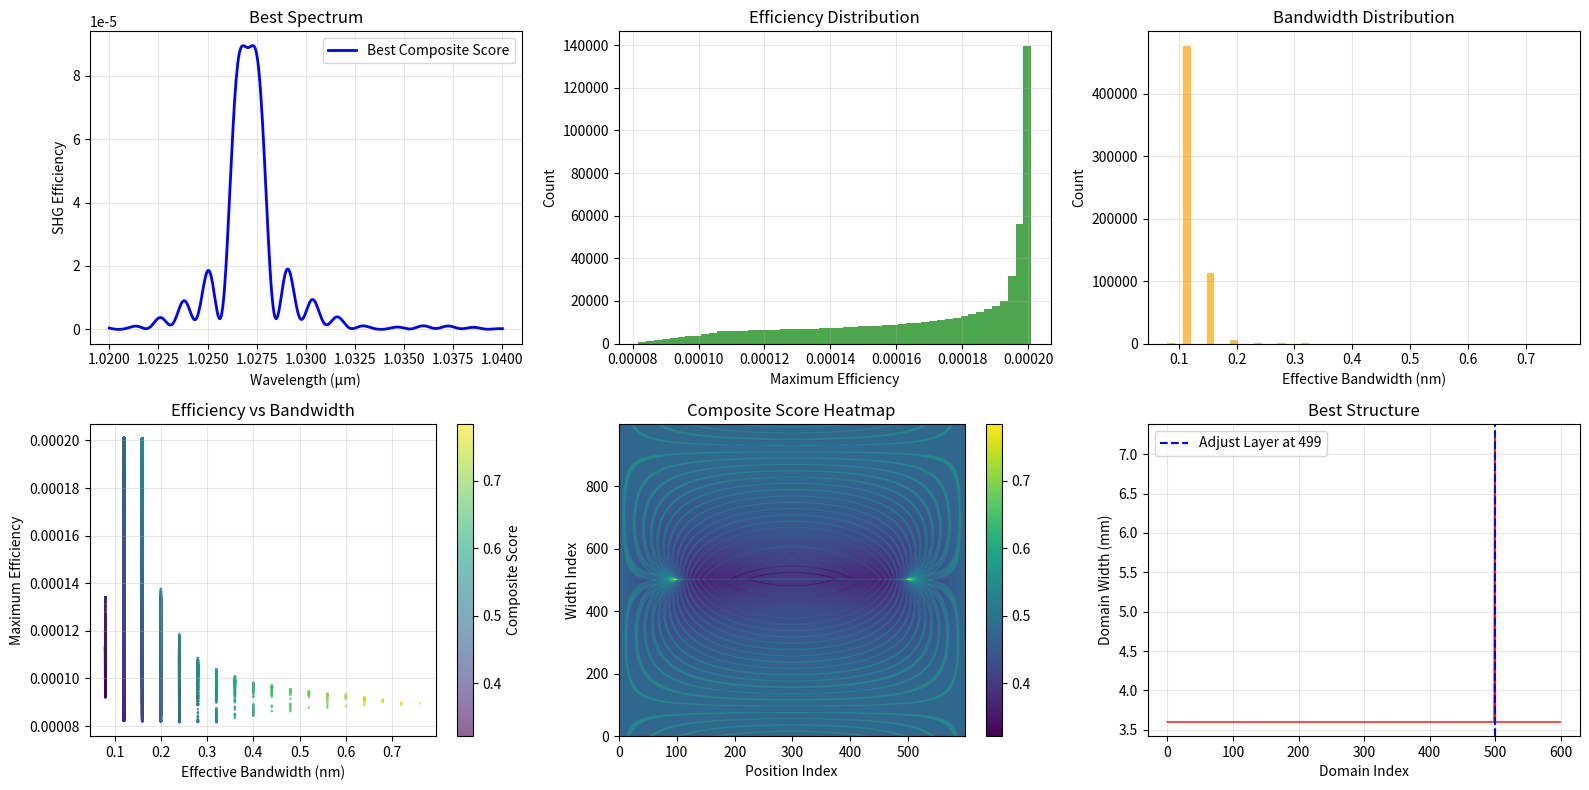

In [7]:
# ÁµêÊûú„ÅÆÂèØË¶ñÂåñÔºà„Ç∑„É≥„Éó„É´ÁâàÔºâ
fig = plt.figure(figsize=(16, 8))

# 1. ÊúÄÈÅ©„Çπ„Éö„ÇØ„Éà„É©„É†
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(WAVELENGTH_RANGE, best_spectrum, 'b-',
         linewidth=2, label='Best Composite Score')
ax1.set_xlabel('Wavelength (Œºm)')
ax1.set_ylabel('SHG Efficiency')
ax1.set_title('Best Spectrum')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ÂäπÁéáÂàÜÂ∏É
ax2 = fig.add_subplot(2, 3, 2)
ax2.hist(max_efficiencies, bins=50, alpha=0.7, color='green')
ax2.set_xlabel('Maximum Efficiency')
ax2.set_ylabel('Count')
ax2.set_title('Efficiency Distribution')
ax2.grid(True, alpha=0.3)

# 3. ÂÆüÂäπÂ∏ØÂüüÂπÖÂàÜÂ∏É
ax3 = fig.add_subplot(2, 3, 3)
ax3.hist(effective_bandwidths*1000, bins=50, alpha=0.7, color='orange')
ax3.set_xlabel('Effective Bandwidth (nm)')
ax3.set_ylabel('Count')
ax3.set_title('Bandwidth Distribution')
ax3.grid(True, alpha=0.3)

# 4. ÂäπÁéá vs ÂÆüÂäπÂ∏ØÂüüÂπÖ„ÅÆÊï£Â∏ÉÂõ≥
ax4 = fig.add_subplot(2, 3, 4)
scatter = ax4.scatter(effective_bandwidths*1000, max_efficiencies, c=composite_scores,
                      cmap='viridis', alpha=0.6, s=1)
ax4.set_xlabel('Effective Bandwidth (nm)')
ax4.set_ylabel('Maximum Efficiency')
ax4.set_title('Efficiency vs Bandwidth')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Composite Score')

# 5. Ë§áÂêà„Çπ„Ç≥„Ç¢„ÅÆ„Éí„Éº„Éà„Éû„ÉÉ„Éó
ax5 = fig.add_subplot(2, 3, 5)
score_reshaped = composite_scores.reshape(
    len(adjust_widths), len(adjust_positions))
im = ax5.imshow(score_reshaped, aspect='auto', cmap='viridis', origin='lower')
ax5.set_xlabel('Position Index')
ax5.set_ylabel('Width Index')
ax5.set_title('Composite Score Heatmap')
plt.colorbar(im, ax=ax5)

# 6. ÊúÄÈÅ©ÊßãÈÄ†
ax6 = fig.add_subplot(2, 3, 6)
best_structure = pros_tensor[best_idx, :, 0]
ax6.plot(range(TOTAL_DOMAINS), best_structure, 'r-', linewidth=1)
ax6.axvline(x=best_position, color='blue', linestyle='--',
            label=f"Adjust Layer at {best_position}")
ax6.set_xlabel('Domain Index')
ax6.set_ylabel('Domain Width (mm)')
ax6.set_title('Best Structure')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== ‰øÆÊ≠£Âæå„ÅÆË´ñÊñáÊù°‰ª∂Ê§úË®º ===
Ë´ñÊñáÊù°‰ª∂: ÂπÖ=7.2mm, ‰ΩçÁΩÆ=99
Êé¢Á¥¢ÁÇπ: ÂπÖ=7.196mm, ‰ΩçÁΩÆ=99

‰øÆÊ≠£Âæå„ÅÆÊé¢Á¥¢ÁµêÊûú„Åß„ÅÆË´ñÊñáÊù°‰ª∂:
- ÊúÄÂ§ßÂäπÁéá: 0.00009038
- ÂÆüÂäπÂ∏ØÂüüÂπÖ: 0.7 nm
- Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢: 0.997600
- Ë§áÂêà„Çπ„Ç≥„Ç¢: 0.752028

Âçò‰ΩìÂÜçË®àÁÆóÔºà‰øÆÊ≠£ÁâàÔºâ:
- ÊúÄÂ§ßÂäπÁéá: 0.00009038
- ÂÆüÂäπÂ∏ØÂüüÂπÖ: 0.7 nm
- Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢: 0.997600
- Ë§áÂêà„Çπ„Ç≥„Ç¢: 0.752028

„Çπ„Ç≥„Ç¢„ÅÆÂ∑Æ: 0.00000000
‚úÖ ‰øÆÊ≠£ÊàêÂäüÔºÅÊé¢Á¥¢ÁµêÊûú„Å®ÂÜçË®àÁÆó„Åå‰∏ÄËá¥

=== ÊúÄÈÅ©Ëß£„ÅÆÁ¢∫Ë™ç ===
Êñ∞„Åó„ÅÑÊúÄÈÅ©„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: 299498
Êñ∞„Åó„ÅÑÊúÄÈÅ©Ë§áÂêà„Çπ„Ç≥„Ç¢: 0.783953
Ë´ñÊñáÊù°‰ª∂„ÅÆË§áÂêà„Çπ„Ç≥„Ç¢: 0.752028
‚úÖ Ë´ñÊñáÊù°‰ª∂„ÅØ‰∏ä‰Ωç„ÅÆËß£„Åß„Åô
Ë´ñÊñáÊù°‰ª∂„ÅÆ„É©„É≥„Ç≠„É≥„Ç∞: 10/598000 (‰∏ä‰Ωç0.00%)


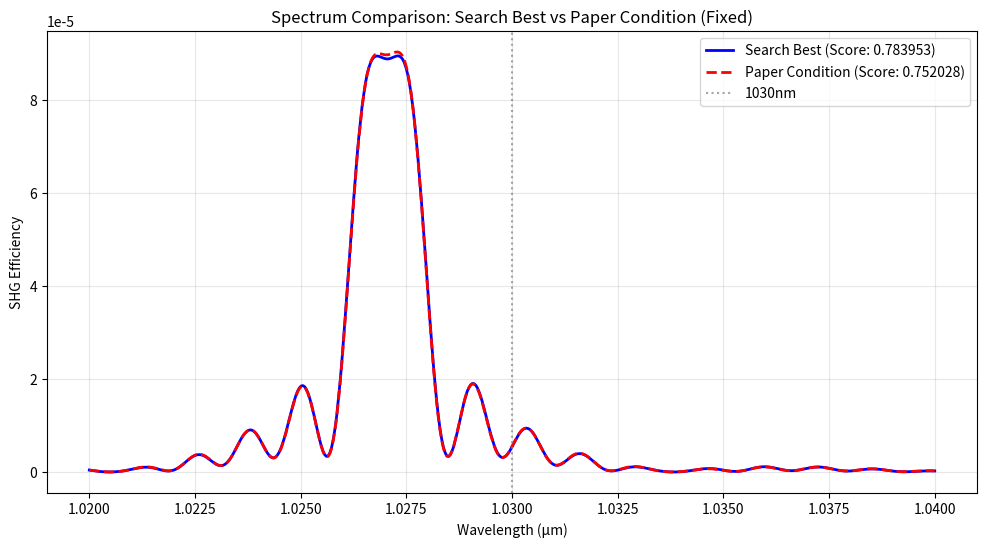

In [8]:
# ‰øÆÊ≠£Âæå„ÅÆË´ñÊñáÊù°‰ª∂Ê§úË®º
print("=== ‰øÆÊ≠£Âæå„ÅÆË´ñÊñáÊù°‰ª∂Ê§úË®º ===")

# Ë´ñÊñáÊù°‰ª∂„ÅÆ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
paper_optimal_position = int(0.165 * TOTAL_DOMAINS)
width_ratios = jnp.linspace(ADJUST_WIDTH_MIN/PERIOD,
                            ADJUST_WIDTH_MAX/PERIOD, NUM_WIDTH_STEPS)
closest_width_idx = jnp.argmin(jnp.abs(width_ratios - 1.0))
closest_pos_idx = jnp.argmin(
    jnp.abs(adjust_positions - paper_optimal_position))
paper_test_idx = closest_width_idx * len(adjust_positions) + closest_pos_idx

print(f"Ë´ñÊñáÊù°‰ª∂: ÂπÖ={PERIOD:.1f}mm, ‰ΩçÁΩÆ={paper_optimal_position}")
print(
    f"Êé¢Á¥¢ÁÇπ: ÂπÖ={adjust_widths[closest_width_idx]:.3f}mm, ‰ΩçÁΩÆ={adjust_positions[closest_pos_idx]}")

# Êé¢Á¥¢ÁµêÊûú„Åã„ÇâË´ñÊñáÊù°‰ª∂„ÅÆË©ï‰æ°„ÇíÂèñÂæó
paper_search_eff = max_efficiencies[paper_test_idx]
paper_search_eff_bw = effective_bandwidths[paper_test_idx]
paper_search_flatness = flatness_scores[paper_test_idx]
paper_search_composite = composite_scores[paper_test_idx]

print(f"\n‰øÆÊ≠£Âæå„ÅÆÊé¢Á¥¢ÁµêÊûú„Åß„ÅÆË´ñÊñáÊù°‰ª∂:")
print(f"- ÊúÄÂ§ßÂäπÁéá: {paper_search_eff:.8f}")
print(f"- ÂÆüÂäπÂ∏ØÂüüÂπÖ: {paper_search_eff_bw*1000:.1f} nm")
print(f"- Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢: {paper_search_flatness:.6f}")
print(f"- Ë§áÂêà„Çπ„Ç≥„Ç¢: {paper_search_composite:.6f}")

# Âçò‰Ωì„ÅßÂÜçË®àÁÆóÔºà‰øÆÊ≠£ÁâàÈñ¢Êï∞‰ΩøÁî®Ôºâ
paper_spectrum = power[paper_test_idx, :]
paper_single_eff_bw, paper_single_flatness, paper_single_composite = calculate_single_metrics(
    paper_spectrum)

print(f"\nÂçò‰ΩìÂÜçË®àÁÆóÔºà‰øÆÊ≠£ÁâàÔºâ:")
print(f"- ÊúÄÂ§ßÂäπÁéá: {jnp.max(paper_spectrum):.8f}")
print(f"- ÂÆüÂäπÂ∏ØÂüüÂπÖ: {paper_single_eff_bw[0]*1000:.1f} nm")
print(f"- Âπ≥Âù¶ÊÄß„Çπ„Ç≥„Ç¢: {paper_single_flatness[0]:.6f}")
print(f"- Ë§áÂêà„Çπ„Ç≥„Ç¢: {paper_single_composite[0]:.6f}")

# ‰∏ÄËá¥Á¢∫Ë™ç
score_diff = abs(paper_search_composite - paper_single_composite[0])
print(f"\n„Çπ„Ç≥„Ç¢„ÅÆÂ∑Æ: {score_diff:.8f}")

if score_diff < 1e-6:
    print("‚úÖ ‰øÆÊ≠£ÊàêÂäüÔºÅÊé¢Á¥¢ÁµêÊûú„Å®ÂÜçË®àÁÆó„Åå‰∏ÄËá¥")
else:
    print("‚ùå „Åæ„Å†ÂïèÈ°å„ÅåÊÆã„Å£„Å¶„ÅÑ„Çã")

# ÊúÄÈÅ©Ëß£„ÅÆÊõ¥Êñ∞Á¢∫Ë™ç
best_idx_new = jnp.argmax(composite_scores)
best_composite_new = composite_scores[best_idx_new]

print(f"\n=== ÊúÄÈÅ©Ëß£„ÅÆÁ¢∫Ë™ç ===")
print(f"Êñ∞„Åó„ÅÑÊúÄÈÅ©„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: {best_idx_new}")
print(f"Êñ∞„Åó„ÅÑÊúÄÈÅ©Ë§áÂêà„Çπ„Ç≥„Ç¢: {best_composite_new:.6f}")
print(f"Ë´ñÊñáÊù°‰ª∂„ÅÆË§áÂêà„Çπ„Ç≥„Ç¢: {paper_search_composite:.6f}")

if paper_test_idx == best_idx_new:
    print("üéâ Ë´ñÊñáÊù°‰ª∂„ÅåÊúÄÈÅ©Ëß£„Å®„Åó„Å¶ÈÅ∏„Å∞„Çå„Åæ„Åó„ÅüÔºÅ")
elif paper_search_composite > best_composite_new * 0.95:
    print("‚úÖ Ë´ñÊñáÊù°‰ª∂„ÅØ‰∏ä‰Ωç„ÅÆËß£„Åß„Åô")

    # Ë´ñÊñáÊù°‰ª∂„ÅÆ„É©„É≥„Ç≠„É≥„Ç∞
    ranking = jnp.sum(composite_scores >= paper_search_composite)
    total_patterns = len(composite_scores)
    print(
        f"Ë´ñÊñáÊù°‰ª∂„ÅÆ„É©„É≥„Ç≠„É≥„Ç∞: {ranking}/{total_patterns} (‰∏ä‰Ωç{ranking/total_patterns*100:.2f}%)")
else:
    print("‚ùì Ë´ñÊñáÊù°‰ª∂„Çà„ÇäËâØ„ÅÑËß£„ÅåÂ≠òÂú®„Åó„Åæ„Åô")

# „Çπ„Éö„ÇØ„Éà„É´ÊØîËºÉÔºàÊúÄÈÅ©Ëß£„ÅåÂ§â„Çè„Å£„ÅüÂ†¥Âêà„ÅÆÊõ¥Êñ∞Ôºâ
best_spectrum_new = power[best_idx_new, :]

plt.figure(figsize=(12, 6))
plt.plot(WAVELENGTH_RANGE, best_spectrum_new, 'b-', linewidth=2,
         label=f'Search Best (Score: {best_composite_new:.6f})')
plt.plot(WAVELENGTH_RANGE, paper_spectrum, 'r--', linewidth=2,
         label=f'Paper Condition (Score: {paper_search_composite:.6f})')
plt.axvline(x=1.030, color='gray', linestyle=':', alpha=0.7, label='1030nm')
plt.xlabel('Wavelength (Œºm)')
plt.ylabel('SHG Efficiency')
plt.title('Spectrum Comparison: Search Best vs Paper Condition (Fixed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()